# Disaster Tweets

Initial plan is to use this notebook for data exploration and preprocessing.

In [1]:
# imports

# data
import pandas as pd
import numpy as np

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup 

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from category_encoders import WOEEncoder
from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
# from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
# # XGBoost
# import xgboost as xgb
# from xgboost import XGBClassifier

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

/Users/davidwalkup/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read training and test data
train_df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
no_keyword = train_df.loc[train_df['keyword'].isna() == True].index
train_df['keyword'].loc[no_keyword] = 'no_keyword'

In [6]:
no_location = train_df.loc[train_df['location'].isna() == True].index
train_df['location'].loc[no_location] = 'no_location'

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [10]:
no_keyword = test_df.loc[test_df['keyword'].isna() == True].index
test_df['keyword'].loc[no_keyword] = 'no_keyword'

In [11]:
no_location = test_df.loc[test_df['location'].isna() == True].index
test_df['location'].loc[no_location] = 'no_location'

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3263 non-null   object
 2   location  3263 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [13]:
test_df.head()

,id,keyword,location,text
0,0,no_keyword,no_location,Just happened a terrible car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s..."
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are..."
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan


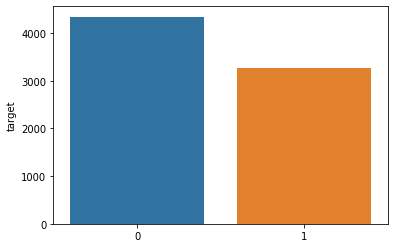

In [14]:
sns.barplot(train_df['target'].value_counts().index, train_df['target'].value_counts());

In [15]:
# how good do I have to be to beat just saying "not a disaster" for every observation?
p_classes = dict(train_df['target'].value_counts(normalize=True))
naive_approach = p_classes[0]
print('Class probabilities: ', p_classes,
      '\nChance tweet is not about a real disaster: ', np.round(naive_approach, decimals = 4))

Class probabilities:  {0: 0.5703402075397347, 1: 0.4296597924602653} 
Chance tweet is not about a real disaster:  0.5703


In [16]:
train_df['text'].sample(5)

4770    World War II book LIGHTNING JOE An Autobiograp...
2397    @GoP establishment is working overtime to dera...
5903    Watch This Airport Get Swallowed Up By A Sands...
4181    @LongBreastYat Yeah I don't think he's elite e...
783                                   @kynespeace *blight
Name: text, dtype: object

In [ ]:
# example for finding text in square brackets
# train_df.loc[train_df['text'].apply(lambda x: re.search(r'\[.*?\]', x)).isna() == False]

In [ ]:
# example for finding retweets
# train_df['text'].loc[train_df['text'].apply(lambda x: 'rt ' in x)]

In [17]:
def text_cleaner(text):
    text = text.lower()
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    text = [word for word in text if word not in string.punctuation]
    text = ' '.join(text)
    return text

In [18]:
train_df['text'] = train_df['text'].apply(lambda x: text_cleaner(x))

In [19]:
count_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                   stop_words = stopwords.words('english'),
                                   ngram_range = (1, 3),
                                   binary = True)

In [20]:
train_vector_df = count_vectorizer.fit_transform(train_df['text'])

In [21]:
train_vector_df.shape

(7613, 132881)

In [23]:
# w/no cleaning: 0.5970784000653343 +/- 0.06368841665479281
# w/cleaning: 0.5979479898225941 +/- 0.06349283339951738
clf = LogisticRegression()
scores = model_selection.cross_val_score(clf, train_vector_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

0.5979479898225941 +/- 0.06349283339951738


In [ ]:
# w/no cleaning: 0.5970784000653343 +/- 0.06368841665479281
# w/cleaning: 0.5979479898225941 +/- 0.06349283339951738
encoder = WOEEncoder()
clf = LogisticRegression()
scorecard = make_pipeline(encoder, clf)
scores = model_selection.cross_val_score(scorecard, train_vector_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

In [ ]:
# w/no cleaning: 0.6596471672909543 +/- 0.033935108319165
# w/cleaning: 0.6594763720845761 +/- 0.03341037684629987
clf = MultinomialNB()
scores = model_selection.cross_val_score(clf, train_vector_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

In [ ]:
tf_idf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 3))

In [ ]:
train_tfidf_df = tf_idf.fit_transform(train_df['text'])

In [ ]:
# w/no cleaning: 0.6117845209530192 +/- 0.0530940957853178
# w/cleaning: 0.6116640233118774 +/- 0.054064619690216614
clf = LogisticRegression()
scores = model_selection.cross_val_score(clf, train_tfidf_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

In [ ]:
# w/no cleaning: 0.6092126780070748 +/- 0.06534813484665665
# w/cleaning: 0.609552450352553 +/- 0.06450734863558556
clf = MultinomialNB()
scores = model_selection.cross_val_score(clf, train_tfidf_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())